This notebooks explores the performance of ETFs to see which would be the most useful to invest

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import minimize, LinearConstraint

In [2]:
ETF_DATA_FILEPATH = "../data/raw/ETF_data.pkl"
ETF_METADATA_FILEPATH = "../data/raw/ETF_metadata.csv"
NUM_DAYS_TIME_HORIZON = 365
BENCHMARK_SYMBOL = "SPY"  # use the S&P 500 ETF to normalize
ANALYSIS_COLUMN = "Adj Close"  # includes more info representative of the value. Not exactly the price.

In [3]:
etf_data = pd.read_pickle(ETF_DATA_FILEPATH)
etf_data

XBI                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2016-06-27   51.320000   52.040001   49.509998   49.680000   49.282257   
2016-06-28   50.790001   52.139999   50.599998   52.000000   51.583679   
2016-06-29   53.230000   54.259998   52.830002   54.060001   53.627186   
2016-06-30   53.889999   54.480000   53.020000   54.080002   53.647030   
2016-07-01   53.830002   55.880001   53.799999   55.810001   55.363182   
...                ...         ...         ...         ...         ...   
2021-06-21  133.929993  135.279999  132.190002  134.789993  134.789993   
2021-06-22  134.630005  134.889999  131.889999  133.679993  133.679993   
2021-06-23  133.279999  135.059998  132.580002  134.309998  134.309998   
2021-06-24  135.210007  137.429993  135.119995  137.289993  137.289993   
2021-06-25  137.690002  138.779999  136.509995  138.679993  138.679993   

                            VIXY                                      ...  \
              Volume        Open        High         Low       Close  ...   
Date                                                                  ...   
2016-06-27  13702700  896.000000  947.200012  886.400024  890.400024  ...   
2016-06-28   6876700  857.599976  858.400024  798.400024  800.000000  ...   
2016-06-29   7892200  776.000000  776.799988  748.799988  757.599976  ...   
2016-06-30   7521400  747.200012  757.599976  728.799988  732.799988  ...   
2016-07-01   9345900  728.000000  731.200012  707.200012  711.200012  ...   
...              ...         ...         ...         ...         ...  ...   
2021-06-21   5111700   27.370001   28.200001   26.200001   26.500000  ...   
2021-06-22   4485000   26.799999   26.910000   25.240000   25.270000  ...   
2021-06-23   4142400   24.950001   25.020000   24.520000   24.770000  ...   
2021-06-24   5967900   24.150000   24.420000   24.049999   24.230000  ...   
2021-06-25   8476600   24.200001   24.450001   23.850000   23.870001  ...   

                   SDOW                                          IEMG  \
                    Low        Close    Adj Close   Volume       Open   
Date                                                                    
2016-06-27  1050.239990  1072.000000  1038.204224    51955  39.650002   
2016-06-28  1022.080017  1022.080017   989.857910    35666  40.259998   
2016-06-29   970.880005   972.159973   941.511597    34031  41.160000   
2016-06-30   934.400024   935.039978   905.561951    48386  41.570000   
2016-07-01   921.599976   929.280029   899.983521    33039  42.049999   
...                 ...          ...          ...      ...        ...   
2021-06-21    34.700001    34.790001    34.790001  4712400  65.820000   
2021-06-22    34.290001    34.599998    34.599998  4060500  65.699997   
2021-06-23    34.380001    34.790001    34.790001  2540400  66.430000   
2021-06-24    33.689999    33.779999    33.779999  4281400  66.720001   
2021-06-25    32.910000    33.049999    33.049999  3586900  67.440002   

                                                                 
                 High        Low      Close  Adj Close   Volume  
Date                                                             
2016-06-27  39.650002  38.860001  39.270000  34.632416  8940600  
2016-06-28  40.439999  40.049999  40.430000  35.655430  7476100  
2016-06-29  41.400002  41.090000  41.389999  36.502056  5285700  
2016-06-30  41.880001  41.389999  41.840000  36.898911  7259300  
2016-07-01  42.240002  42.000000  42.150002  37.172302  5498000  
...               ...        ...        ...        ...      ...  
2021-06-21  66.190002  65.540001  66.169998  66.169998  9682700  
2021-06-22  66.000000  65.480003  65.919998  65.919998  5296700  
2021-06-23  66.739998  66.269997  66.309998  66.309998  6127700  
2021-06-24  66.959999  66.629997  66.889999  66.889999  7899300  
2021-06-25  67.519997 

In [4]:
end_date = datetime.now()
time_horizon = timedelta(days=NUM_DAYS_TIME_HORIZON)
start_date = end_date - time_horizon

In [5]:
filtered_etf_data = etf_data[start_date <= etf_data.index]
daily_prices = pd.DataFrame()
for symbol, subcolumn in filtered_etf_data:
    if subcolumn == ANALYSIS_COLUMN:
        daily_prices[symbol] = filtered_etf_data[symbol][subcolumn]
        
daily_prices

,XBI,VIXY,XLI,SVXY,SPXS,ERX,EWH,IEF,FXI,GLD,...,EWZ,LQD,MCHI,EEM,XME,FNGU,INDA,JDST,SDOW,IEMG
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-29,110.153503,117.120003,67.344322,30.709999,81.599998,14.066060,20.910383,121.090446,39.327114,166.630005,...,28.300264,130.832062,64.930893,39.536346,20.673798,8.898000,29.158585,18.100000,98.400002,46.941887
2020-06-30,111.700043,111.040001,67.728798,31.500000,78.099998,14.709414,20.881073,120.872238,38.983437,167.369995,...,28.114529,131.202759,64.812065,39.408245,20.990791,9.392000,28.968920,16.980000,96.160004,46.706387
2020-07-01,112.218880,107.919998,67.423180,31.959999,76.599998,14.007573,21.008097,120.683624,39.435127,166.619995,...,29.033432,131.720963,65.386414,39.851692,20.535114,10.095000,29.617777,17.030001,96.760002,47.314751
2020-07-02,112.637939,106.080002,68.004845,32.240002,75.400002,14.280510,21.555285,120.832542,40.711666,166.979996,...,28.798817,132.043610,67.574867,40.758312,20.574741,10.573000,30.316544,17.170000,95.480003,48.384289
2020-07-06,112.667870,106.000000,68.980843,32.200001,72.000000,14.407231,22.366295,120.653854,44.580555,167.979996,...,29.717720,132.385803,72.486519,42.512417,21.030413,12.265000,30.955416,16.360001,90.519997,50.435051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-21,134.789993,26.500000,101.480003,53.299999,25.370001,28.526001,26.620001,115.169998,45.549999,166.949997,...,40.830002,133.559998,80.269997,54.459999,42.080002,32.220001,44.580002,9.760000,34.790001,66.169998
2021-06-22,133.679993,25.270000,101.589996,54.419998,25.000000,28.889999,26.590000,115.379997,45.180000,166.250000,...,41.189999,133.779999,79.690002,54.209999,42.340000,33.570000,44.459999,9.930000,34.599998,65.919998
2021-06-23,134.309998,24.770000,101.360001,54.939999,25.049999,29.040001,26.760000,115.150002,45.750000,166.139999,...,41.090000,133.570007,80.720001,54.540001,42.759998,34.950001,44.250000,10.070000,34.790001,66.309998


In [6]:
normalized_prices  = (daily_prices-daily_prices.iloc[0]).div(daily_prices[BENCHMARK_SYMBOL], axis=0)
normalized_prices

,XBI,VIXY,XLI,SVXY,SPXS,ERX,EWH,IEF,FXI,GLD,...,EWZ,LQD,MCHI,EEM,XME,FNGU,INDA,JDST,SDOW,IEMG
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-06-30,0.005073,-0.019946,0.001261,0.002592,-0.011482,0.002111,-0.000096,-0.000716,-0.001127,0.002428,...,-0.000609,0.001216,-0.000390,-0.000420,0.001040,0.001621,-0.000622,-0.003674,-0.007348,-0.000773
2020-07-01,0.006728,-0.029971,0.000257,0.004072,-0.016289,-0.000191,0.000318,-0.001325,0.000352,-0.000033,...,0.002388,0.002896,0.001484,0.001027,-0.000452,0.003899,0.001496,-0.003486,-0.005343,0.001215
2020-07-02,0.008049,-0.035768,0.002140,0.004957,-0.020087,0.000695,0.002089,-0.000836,0.004486,0.001134,...,0.001615,0.003925,0.008566,0.003959,-0.000321,0.005427,0.003752,-0.003013,-0.009460,0.004673
2020-07-06,0.008022,-0.035480,0.005222,0.004754,-0.030630,0.001089,0.004645,-0.001393,0.016762,0.004307,...,0.004523,0.004957,0.024107,0.009495,0.001138,0.010743,0.005733,-0.005552,-0.025142,0.011145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-21,0.058538,-0.215321,0.081109,0.053676,-0.133607,0.034358,0.013567,-0.014068,0.014786,0.000760,...,0.029772,0.006482,0.036447,0.035460,0.050863,0.055415,0.036643,-0.019817,-0.151143,0.045688
2021-06-22,0.055604,-0.217083,0.080938,0.056037,-0.133771,0.035036,0.013424,-0.013496,0.013833,-0.000898,...,0.030464,0.006967,0.034882,0.034680,0.051207,0.058311,0.036164,-0.019309,-0.150788,0.044854
2021-06-23,0.057162,-0.218528,0.080491,0.057336,-0.133814,0.035433,0.013842,-0.014057,0.015198,-0.001160,...,0.030264,0.006479,0.037362,0.035503,0.052263,0.061647,0.035711,-0.019001,-0.150521,0.045831


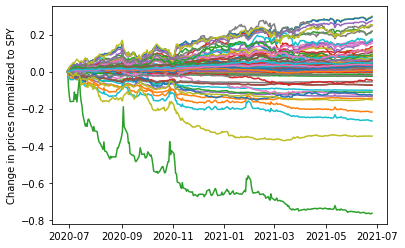

In [7]:
# plot the growth of all etfs
plt.plot(normalized_prices)
plt.ylabel(f"Change in prices normalized to {BENCHMARK_SYMBOL}")
None

Text(0, 0.5, 'Change in prices normalized to SPY')

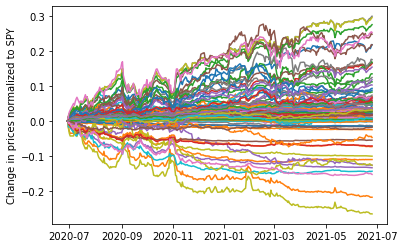

In [8]:
# Filter out outliers
filtered_normalized_prices = normalized_prices.loc[:, normalized_prices.loc["2021-05-14", :] >= -0.3]
# plot the growth of all etfs
plt.plot(filtered_normalized_prices)
plt.ylabel(f"Change in prices normalized to {BENCHMARK_SYMBOL}")

In [9]:
covariances = filtered_normalized_prices.cov()
covariances

,XBI,VIXY,XLI,SVXY,SPXS,ERX,EWH,IEF,FXI,GLD,...,EWZ,LQD,MCHI,EEM,XME,FNGU,INDA,JDST,SDOW,IEMG
XBI,0.001702,-0.001230,0.000534,0.000239,-0.000856,0.000291,1.541094e-04,-0.000142,0.000274,-0.000445,...,0.000224,9.975355e-07,0.000535,0.000415,0.000447,0.000608,0.000313,0.000012,-0.001059,0.000508
VIXY,-0.001230,0.002775,-0.001306,-0.000729,0.001614,-0.000657,-2.608645e-04,0.000326,-0.000208,0.000576,...,-0.000331,1.187726e-04,-0.000438,-0.000536,-0.000933,-0.000717,-0.000495,0.000051,0.002095,-0.000686
XLI,0.000534,-0.001306,0.000647,0.000355,-0.000772,0.000346,1.304081e-04,-0.000167,0.000090,-0.000303,...,0.000162,-7.117306e-05,0.000189,0.000254,0.000470,0.000330,0.000237,-0.000018,-0.001014,0.000326
SVXY,0.000239,-0.000729,0.000355,0.000215,-0.000408,0.000201,6.966717e-05,-0.000090,0.000037,-0.000157,...,0.000098,-3.556925e-05,0.000078,0.000131,0.000259,0.000168,0.000125,-0.000011,-0.000535,0.000170
SPXS,-0.000856,0.001614,-0.000772,-0.000408,0.001004,-0.000383,-1.616502e-04,0.000193,-0.000154,0.000344,...,-0.000200,6.723984e-05,-0.000321,-0.000344,-0.000558,-0.000484,-0.000307,0.000032,0.001291,-0.000437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FNGU,0.000608,-0.000717,0.000330,0.000168,-0.000484,0.000170,8.274703e-05,-0.000089,0.000113,-0.000201,...,0.000092,-2.960259e-05,0.000236,0.000196,0.000252,0.000324,0.000158,-0.000008,-0.000603,0.000244
INDA,0.000313,-0.000495,0.000237,0.000125,-0.000307,0.000134,5.317289e-05,-0.000062,0.000054,-0.000120,...,0.000070,-2.211155e-05,0.000111,0.000116,0.000182,0.000158,0.000105,-0.000007,-0.000396,0.000147
JDST,0.000012,0.000051,-0.000018,-0.000011,0.000032,0.000005,1.053893e-07,-0.000002,0.000002,-0.000054,...,-0.000007,-5.599017e-06,-0.000003,-0.000004,-0.000011,-0.000008,-0.000007,0.000017,0.000036,-0.000006
SDOW,-0.001059,0.002095,-0.001014,-0.000535,0.001291,-0.000512,-2.110151e-04,0.000256,-0.000187,0.000468,...,-0.000255,9.750362e-05,-0.000389,-0.000437,-0.000730,-0.000603,-0.000396,0.000036,0.001681,-0.000556


In [10]:
sigma = np.array(covariances)
sigma

array([[ 1.70156673e-03, -1.23003309e-03,  5.34107945e-04, ...,
         1.20483908e-05, -1.05894834e-03,  5.07706637e-04],
       [-1.23003309e-03,  2.77480092e-03, -1.30644750e-03, ...,
         5.09960401e-05,  2.09471231e-03, -6.85596069e-04],
       [ 5.34107945e-04, -1.30644750e-03,  6.47478241e-04, ...,
        -1.84907721e-05, -1.01369137e-03,  3.26084068e-04],
       ...,
       [ 1.20483908e-05,  5.09960401e-05, -1.84907721e-05, ...,
         1.69128733e-05,  3.62309255e-05, -5.81838040e-06],
       [-1.05894834e-03,  2.09471231e-03, -1.01369137e-03, ...,
         3.62309255e-05,  1.68112269e-03, -5.56310042e-04],
       [ 5.07706637e-04, -6.85596069e-04,  3.26084068e-04, ...,
        -5.81838040e-06, -5.56310042e-04,  2.20087171e-04]])

In [11]:
mu = []
num_dates = len(filtered_normalized_prices)
X = np.arange(len(filtered_normalized_prices))[..., np.newaxis]  # assume constant spacing in days
lr = LinearRegression()
for symbol in filtered_normalized_prices:
    lr.fit(X, filtered_normalized_prices[symbol])
    mu.append(lr.predict([[num_dates]]))

mu = np.array(mu)
mu.transpose().shape

(1, 98)

In [12]:
symbols = filtered_normalized_prices.columns
symbols

Index(['XBI', 'VIXY', 'XLI', 'SVXY', 'SPXS', 'ERX', 'EWH', 'IEF', 'FXI', 'GLD',
       'XLB', 'PDBC', 'ARKK', 'UPRO', 'SPLV', 'SH', 'SJNK', 'IVV', 'USMV',
       'ICLN', 'EWY', 'SOXL', 'IEFA', 'EWT', 'EZU', 'VTI', 'EWC', 'TBT', 'VXX',
       'RSX', 'VEA', 'SRTY', 'XLP', 'JNK', 'EWU', 'PFF', 'GDX', 'XLY', 'SPXU',
       'IBB', 'BKLN', 'SDS', 'IJR', 'XLV', 'XLK', 'IYR', 'XLU', 'KRE', 'SPY',
       'VGK', 'DIA', 'GDXJ', 'TQQQ', 'XLRE', 'XLC', 'SMH', 'EWJ', 'TNA', 'VWO',
       'SOXS', 'PSQ', 'QID', 'VOO', 'USO', 'SCO', 'FNGD', 'IAU', 'BND', 'LABD',
       'GOVT', 'JETS', 'AGG', 'HYG', 'SQQQ', 'SPXL', 'IWM', 'VNQ', 'XLE',
       'VCIT', 'EFA', 'ARKG', 'TLT', 'PGX', 'SLV', 'XOP', 'EMB', 'QQQ', 'XLF',
       'EWZ', 'LQD', 'MCHI', 'EEM', 'XME', 'FNGU', 'INDA', 'JDST', 'SDOW',
       'IEMG'],
      dtype='object')

In [13]:
def objective(portfolio_weights: np.ndarray, tradeoff_parameter: float) ->  float:
    return - expected_return(portfolio_weights) + tradeoff_parameter * weighted_covariance(portfolio_weights)

def expected_return(portfolio_weights: np.ndarray, mu: np.ndarray = mu) -> float:
    return portfolio_weights.transpose() @ mu

def weighted_covariance(portfolio_weights: np.ndarray, covariances: np.ndarray = sigma) -> float:
    return  portfolio_weights.transpose() @ covariances @ portfolio_weights

num_symbols = len(mu)
x0 = np.ones((num_symbols, 1)) / num_symbols
constraints = [
    LinearConstraint(np.ones((1, num_symbols)), np.array([1.0]), np.array([1.0])),
    LinearConstraint(np.identity(num_symbols), np.zeros(num_symbols), np.ones(num_symbols)),
]
result = minimize(objective, x0, args=(100,), constraints=constraints)
result

     fun: array([-0.05996914])
     jac: array([ 1.21086426e-02,  4.71932744e-02, -6.73943106e-03, -1.93574931e-03,
        3.16572762e-02,  8.36419407e-03,  7.93499406e-04,  2.66637187e-04,
       -4.80693532e-03, -1.63442567e-02, -8.20092345e-03,  4.66545112e-04,
       -7.93743134e-03,  1.04505010e-03, -5.03101479e-03,  2.29417300e-03,
       -1.67221669e-03, -1.58719206e-02, -3.04977363e-03, -1.49820512e-03,
        4.01871279e-03,  6.54678280e-03,  1.73444534e-03, -6.41040504e-04,
        1.27304951e-03, -6.54480420e-03, -1.69715378e-04,  5.16349450e-04,
        5.69911445e-02,  3.14077828e-03,  9.49422363e-04,  1.29013145e-02,
       -7.54559087e-03, -8.60106200e-03,  2.59516481e-03, -2.30472861e-03,
       -8.07271292e-03, -1.57455690e-02,  2.38813297e-02,  1.35041415e-02,
       -1.03105791e-03,  4.66409465e-03,  6.93905400e-03, -5.22458553e-03,
       -2.00228533e-03,  3.79467988e-03, -7.26356171e-03,  7.51520181e-03,
       -1.60351228e-02,  1.89397810e-03, -8.89825122e-03, -

In [14]:
lbdas = np.logspace(-2, 3, 20)
xs = []
expected_returns = []
weighted_covariances = []
for i, lbda in enumerate(lbdas):
    result = minimize(objective, x0, args=(lbda,), constraints=constraints)
    xs.append(result.x)
    expected_returns.append(expected_return(result.x))
    weighted_covariances.append(weighted_covariance(result.x))
    print(f"Done with lambda {i+1} of {len(lbdas)}")

Done with lambda 1 of 20
Done with lambda 2 of 20
Done with lambda 3 of 20
Done with lambda 4 of 20
Done with lambda 5 of 20
Done with lambda 6 of 20
Done with lambda 7 of 20
Done with lambda 8 of 20
Done with lambda 9 of 20
Done with lambda 10 of 20
Done with lambda 11 of 20
Done with lambda 12 of 20
Done with lambda 13 of 20
Done with lambda 14 of 20
Done with lambda 15 of 20
Done with lambda 16 of 20
Done with lambda 17 of 20
Done with lambda 18 of 20
Done with lambda 19 of 20
Done with lambda 20 of 20


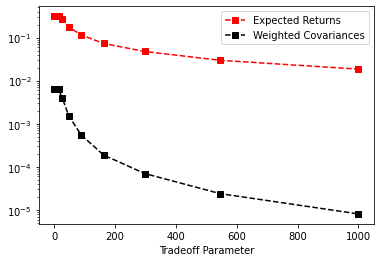

In [15]:
plt.semilogy(lbdas, expected_returns, 'rs--', label="Expected Returns")
plt.semilogy(lbdas, weighted_covariances, 'ks--', label="Weighted Covariances")
plt.legend(loc="best")
plt.xlabel("Tradeoff Parameter")
None

Text(0.5, 0, 'Tradeoff Parameter')

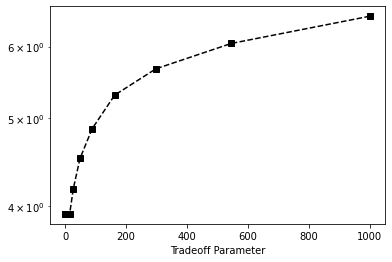

In [16]:
ratio = np.squeeze(np.array(expected_returns)) / np.sqrt(np.array(weighted_covariances))
plt.semilogy(lbdas, ratio, 'ks--')
plt.xlabel("Tradeoff Parameter")


In [17]:
selected_lbda = 100
selected_results = minimize(objective, x0, args=(selected_lbda,), constraints=constraints)
selected_x = selected_results.x
selected_series = pd.Series(selected_x, index=symbols)
selected_series

XBI     3.384033e-17
VIXY    1.782301e-17
XLI     1.353276e-17
SVXY    3.554336e-17
SPXS   -1.395567e-17
            ...     
FNGU   -9.587372e-18
INDA    1.256396e-17
JDST   -3.088040e-17
SDOW   -2.999839e-17
IEMG    1.662795e-18
Length: 98, dtype: float64

In [18]:
filtered_selected_series = selected_series[selected_series > 0.01]
filtered_selected_series = filtered_selected_series / filtered_selected_series.sum(axis=0)
filtered_selected_series

GLD     0.203986
XLY     0.090663
SPY     0.028286
GDXJ    0.353459
QQQ     0.323605
dtype: float64

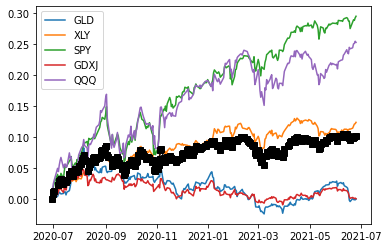

In [19]:
historic_performance = filtered_normalized_prices[filtered_selected_series.index]
aggregated_historic_performance = historic_performance.multiply(filtered_selected_series, axis=1).sum(axis=1)
for symbol in historic_performance:
    plt.plot(historic_performance[symbol], label=symbol)
plt.plot(aggregated_historic_performance, 'ks--')
plt.legend(loc="best")

In [20]:
etf_metadata = pd.read_csv(ETF_METADATA_FILEPATH)
etf_metadata = etf_metadata.set_index("Symbol")
etf_metadata["Weights"] = filtered_selected_series
etf_metadata = etf_metadata[~etf_metadata.Weights.isna()].sort_values("Weights", ascending=False)
etf_metadata

,Name,Avg Daily Share Volume (3mo),AUM,Weights
Symbol,,,,
GDXJ,VanEck Vectors Junior Gold Miners ETF,"6,726,439","$5,799,860.00",0.353459
QQQ,Invesco QQQ,"55,311,926","$155,519,000.00",0.323605
GLD,SPDR Gold Trust,"8,904,771","$60,654,200.00",0.203986
XLY,Consumer Discretionary Select Sector SPDR Fund,"4,206,044","$20,136,300.00",0.090663
SPY,SPDR S&P 500 ETF,"87,215,063","$364,238,000.00",0.028286


Notes
    LQD: Investment grade corporate bonds
    QQQ: Primarily tracks the NASDAQ for large-cap growth.
    IYR: iShares though blackrock, which tracks real estate
    DIA: Dow Jones Industrial average through SPDR
    GLD: ETF backed by gold offered by SPDR
    VXX: Volitility ETF based on the S&P 500. Offers a hedge and filters the swings of DIA. 
    